### 1. Loading the Datasets
Training: Code Red 559 10 Min + Nimda 559 10 Min 

Test: Slammer 559 10 Min

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    precision_recall_fscore_support, roc_curve, auc, 
    precision_recall_curve, average_precision_score
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Import explainability libraries if installed
try:
    import shap
    import lime
    import lime.lime_tabular
    EXPLAINABILITY_AVAILABLE = True
except ImportError:
    EXPLAINABILITY_AVAILABLE = False
    print("Warning: SHAP and/or LIME libraries not installed. Explainability sections will be skipped.")
    print("Run 'pip install shap lime' to install them.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

In [3]:
# Load the first training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/ratios/dataset_nimda_559_5_rrc04.csv"
df = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (2048, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,94,14,0,68,0,0,0.0,0,0.796610,...,0.787234,0.0,0.212766,0.159574,0.250000,0.203390,2001-09-16 00:13:19,1000599199,8,24
1,1,214,12,0,72,0,0,0.0,0,0.616715,...,0.509091,0.0,0.490909,0.373832,0.579710,0.383285,2001-09-16 00:18:19,1000599499,6,133
2,2,252,14,0,172,0,0,0.0,0,0.961832,...,0.818182,0.0,0.181818,0.182540,0.422018,0.038168,2001-09-16 00:23:19,1000599799,6,10
3,3,45,13,0,19,0,0,0.0,0,0.833333,...,0.894737,0.0,0.105263,0.244444,0.523810,0.166667,2001-09-16 00:28:19,1000600099,5,9
4,4,154,11,0,137,0,0,0.0,0,0.581132,...,0.970588,0.0,0.029412,0.064935,0.370370,0.418868,2001-09-16 00:33:19,1000600399,4,111


In [5]:
# Load the second training dataset - update the path to the dataset file you want to use
dataset_path = "../../datasets/ratios/dataset_code-red_559_5_rrc04.csv"
df_2 = pd.read_csv(dataset_path)

# Check the first few rows
print(f"Dataset shape: {df_2.shape}")
df_2.head()

Dataset shape: (1440, 31)


,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp,timestamp2,unique_as_path_avg,withdrawals
0,0,191,17,0,153,0,0,0.0,0,0.864253,...,0.625000,0.0,0.375000,0.581152,0.840909,0.135747,2001-07-17 00:50:50,995331050,6,30
1,1,161,14,0,65,0,18,0.0,0,0.856383,...,0.811111,0.0,0.188889,0.285714,0.522727,0.143617,2001-07-17 00:55:50,995331350,4,27
2,2,246,12,0,98,0,0,0.0,0,0.875445,...,0.891089,0.0,0.108911,0.052846,0.382353,0.124555,2001-07-17 01:00:50,995331650,6,35
3,3,109,10,0,48,0,0,0.0,0,0.819549,...,0.901961,0.0,0.098039,0.201835,0.360656,0.180451,2001-07-17 01:05:50,995331950,4,24
4,4,280,11,0,127,0,0,0.0,0,0.955631,...,0.781250,0.0,0.218750,0.089286,0.462963,0.044369,2001-07-17 01:10:50,995332250,2,13


In [6]:
# Combine the training data
df = pd.concat([df, df_2])
print(f"Dataset shape: {df.shape}")

Dataset shape: (3488, 31)


### 2. Data Exploration and Preprocessing

In [7]:
# Check basic statistics
df.describe()

,Unnamed: 0,announcements,as_path_max,class,nlri_ann,number_rare_ases,origin_changes,rare_ases_avg,rare_ases_max,ratio_ann,...,ratio_news,ratio_origin0,ratio_origin1,ratio_origin2,ratio_shorter,ratio_shorter2,ratio_wd,timestamp2,unique_as_path_avg,withdrawals
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,...,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3.488000e+03,3488.000000,3488.000000
mean,897.823108,200.689507,12.751720,0.229931,123.292718,4.682339,0.926319,0.019920,0.833429,0.813636,...,0.022014,0.823133,0.001212,0.175655,0.242919,0.490802,0.186364,9.986936e+08,5.488245,55.610378
std,546.534426,739.246348,3.075896,0.420849,704.974952,47.236841,3.213111,0.030241,0.824110,0.104873,...,0.062766,0.099680,0.007120,0.099602,0.110910,0.139332,0.104873,2.643711e+06,1.416596,583.896846
min,0.000000,8.000000,6.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.011637,...,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,9.953310e+08,1.000000,0.000000
25%,435.750000,72.000000,11.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.761113,...,0.000000,0.766667,0.000000,0.106383,0.163860,0.417228,0.116655,9.955926e+08,5.000000,13.000000
50%,871.500000,121.000000,12.000000,0.000000,69.000000,1.000000,0.000000,0.009070,1.000000,0.827823,...,0.001844,0.835165,0.000000,0.163636,0.238758,0.500000,0.172177,1.000690e+09,5.000000,23.000000
75%,1307.250000,209.000000,14.000000,0.000000,120.000000,4.000000,1.000000,0.027778,1.000000,0.883345,...,0.018230,0.892857,0.000000,0.231506,0.309747,0.562500,0.238887,1.000952e+09,6.000000,45.000000
max,2016.000000,27432.000000,31.000000,1.000000,26727.000000,2001.000000,76.000000,0.428571,7.000000,1.000000,...,0.953302,1.000000,0.102564,0.800000,0.806818,1.000000,0.988363,1.001204e+09,13.000000,29642.000000


In [8]:
# Check for missing values
print("Missing values in each column:")
df.isnull().sum()

Missing values in each column:


Unnamed: 0            0
announcements         0
as_path_max           0
class                 0
nlri_ann              0
number_rare_ases      0
origin_changes        0
rare_ases_avg         0
rare_ases_max         0
ratio_ann             0
ratio_dups            0
ratio_exp_wd          0
ratio_flaps           0
ratio_imp_wd          0
ratio_imp_wd2         0
ratio_imp_wd_dpath    0
ratio_imp_wd_spath    0
ratio_longer          0
ratio_longer2         0
ratio_nadas           0
ratio_news            0
ratio_origin0         0
ratio_origin1         0
ratio_origin2         0
ratio_shorter         0
ratio_shorter2        0
ratio_wd              0
timestamp             0
timestamp2            0
unique_as_path_avg    0
withdrawals           0
dtype: int64

In [9]:
# Fill missing values with 0 (if any)
df = df.fillna(0)

Class distribution:
class
0    2686
1     802
Name: count, dtype: int64


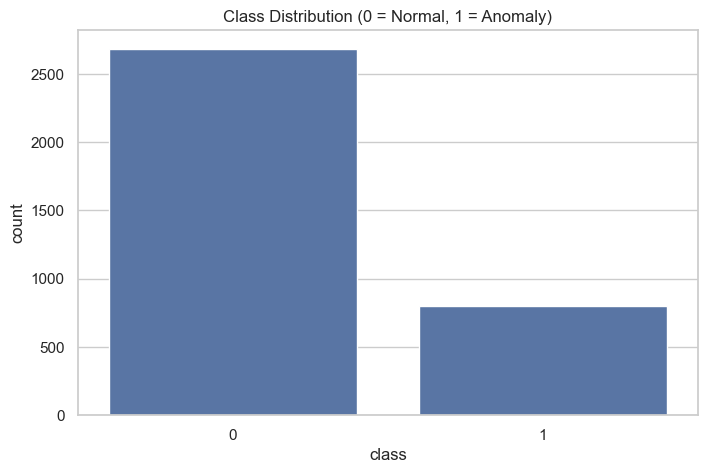

In [10]:
# Check class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Anomaly)')
plt.show()

In [11]:
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Display feature names
print(f"Number of features: {X.shape[1]}")
print("Feature names:")
X.columns.tolist()

Number of features: 27
Feature names:


['announcements',
 'as_path_max',
 'nlri_ann',
 'number_rare_ases',
 'origin_changes',
 'rare_ases_avg',
 'rare_ases_max',
 'ratio_ann',
 'ratio_dups',
 'ratio_exp_wd',
 'ratio_flaps',
 'ratio_imp_wd',
 'ratio_imp_wd2',
 'ratio_imp_wd_dpath',
 'ratio_imp_wd_spath',
 'ratio_longer',
 'ratio_longer2',
 'ratio_nadas',
 'ratio_news',
 'ratio_origin0',
 'ratio_origin1',
 'ratio_origin2',
 'ratio_shorter',
 'ratio_shorter2',
 'ratio_wd',
 'unique_as_path_avg',
 'withdrawals']

### 3. Feature Analysis and Selection

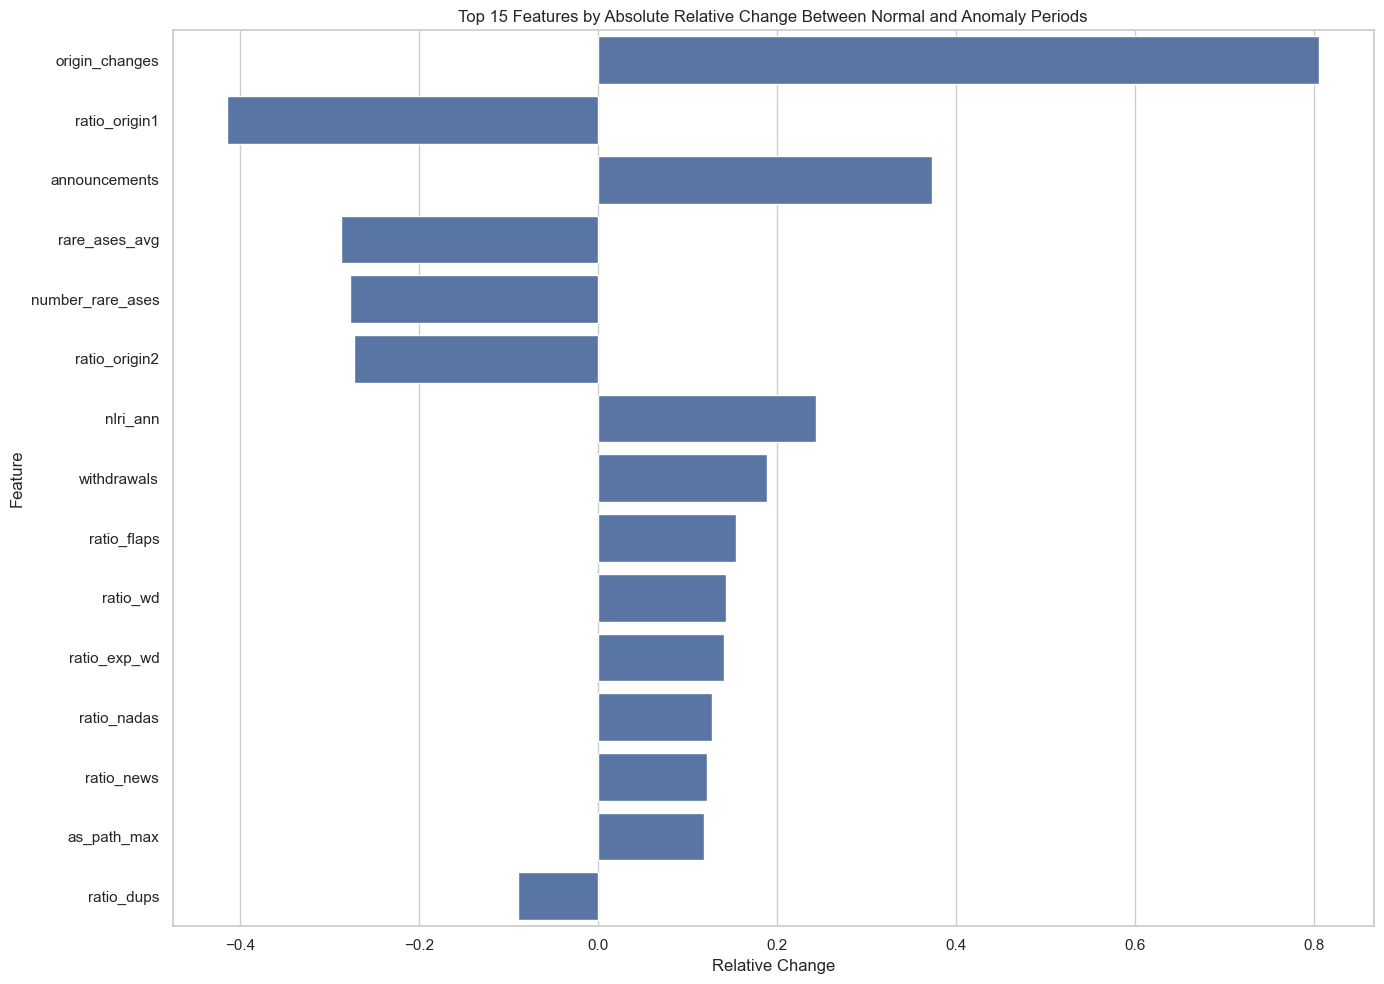

In [12]:
# Analyze feature importance for anomaly detection
# For each feature, calculate the mean difference between normal and anomaly periods
anomaly = df[df['class'] == 1]
normal = df[df['class'] == 0]

# Calculate mean differences
feature_diffs = {}
for col in X.columns:
    if col != 'class':
        normal_mean = normal[col].mean()
        anomaly_mean = anomaly[col].mean() if not anomaly.empty else 0
        
        # Prevent division by zero
        if normal_mean == 0:
            if anomaly_mean == 0:
                diff = 0
            else:
                diff = float('inf')
        else:
            diff = (anomaly_mean - normal_mean) / normal_mean
        
        feature_diffs[col] = diff

# Convert to DataFrame for better visualization
feature_diff_df = pd.DataFrame(list(feature_diffs.items()), columns=['Feature', 'Relative Change'])
feature_diff_df = feature_diff_df.sort_values('Relative Change', key=abs, ascending=False)

# Plot top features by absolute difference
plt.figure(figsize=(14, 10))
sns.barplot(x='Relative Change', y='Feature', data=feature_diff_df.head(15))
plt.title('Top 15 Features by Absolute Relative Change Between Normal and Anomaly Periods')
plt.tight_layout()
plt.show()

In [13]:
# Select top features based on difference analysis
top_features = feature_diff_df.head(15)['Feature'].tolist()
print("Selected top features:")
print(top_features)

# Extract selected features from dataset
X_selected = X[top_features]

Selected top features:
['origin_changes', 'ratio_origin1', 'announcements', 'rare_ases_avg', 'number_rare_ases', 'ratio_origin2', 'nlri_ann', 'withdrawals', 'ratio_flaps', 'ratio_wd', 'ratio_exp_wd', 'ratio_nadas', 'ratio_news', 'as_path_max', 'ratio_dups']


### 4. SVM Model Training and Hyperparameter Tuning

In [15]:
# Define training and test data
y_train = df["class"]
X_train = df.drop(["class"], axis=1)

# Test data
dataset_path = "../../datasets/ratios/dataset_slammer_559_5_rrc04.csv"
df_test = pd.read_csv(dataset_path)
# Drop non-feature columns
columns_to_drop = ['timestamp', 'timestamp2', 'Unnamed: 0']
for col in columns_to_drop:
    if col in df_test.columns:
        df_test = df_test.drop(col, axis=1)
y_test = df_test["class"]
X_test = df_test.drop(["class"], axis=1)

In [16]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [17]:
# # OLD CODE - NOT MULTI CORE
# # Create a pipeline with preprocessing and SVM
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svm', SVC(probability=True))
# ])

# # Define the hyperparameter search space
# param_grid = {
#     'svm__C': [0.1, 1, 10, 100],
#     'svm__gamma': ['scale', 'auto', 0.1, 0.01],
#     'svm__kernel': ['rbf', 'linear', 'poly']
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
# grid_search.fit(X_train, y_train)

# # Print best parameters
# print("Best parameters found:")
# print(grid_search.best_params_)
# print(f"Best CV score: {grid_search.best_score_:.4f}")

In [18]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid, cross_val_score

# keep your pipeline and param_grid
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.1, 0.01],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

best_score = -1
best_params = None

# wrap the list of all param‐combos in tqdm
for params in tqdm(list(ParameterGrid(param_grid)), desc="Grid search"):
    pipeline.set_params(**params)
    # do CV for each combo, still parallel across folds
    scores = cross_val_score(pipeline, X_train, y_train,
                             cv=5, scoring='f1', n_jobs=-1)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score, best_params = mean_score, params

print("Best parameters found:")
print(best_params)
print(f"Best CV score: {best_score:.4f}")



Grid search: 100%|██████████| 48/48 [33:31<00:00, 41.91s/it] 

Best parameters found:
{'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV score: 0.8813


In [20]:
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
best_model = pipeline

# Get the best model
# best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

### 5. Model Evaluation with Advanced Metrics

In [21]:
# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8236
Precision: 0.2879
Recall: 0.0841
F1 Score: 0.1301

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1214
           1       0.29      0.08      0.13       226

    accuracy                           0.82      1440
   macro avg       0.57      0.52      0.52      1440
weighted avg       0.76      0.82      0.78      1440



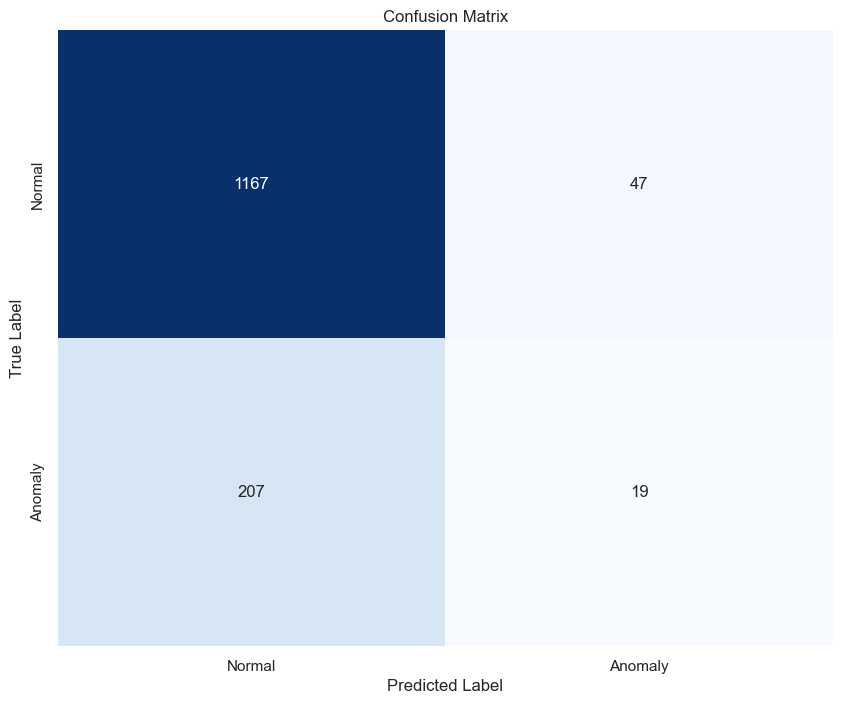

In [22]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

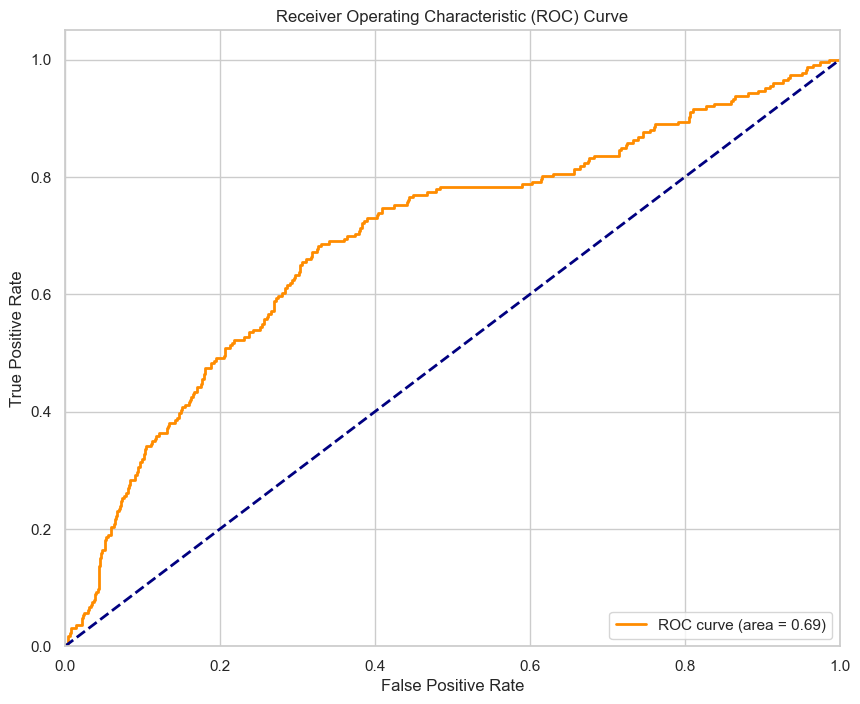

In [23]:
# Calculate and plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

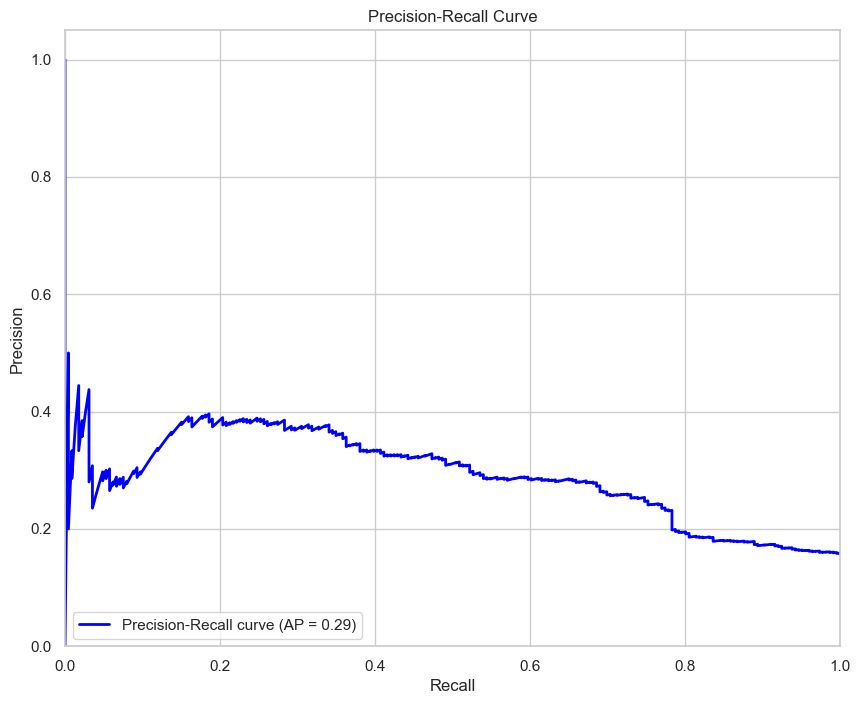

In [24]:
# Calculate and plot Precision-Recall curve
precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### 6. Visualizing Decision Boundaries

Explained variance ratio: [0.18100602 0.1144751 ]
Total explained variance: 0.30


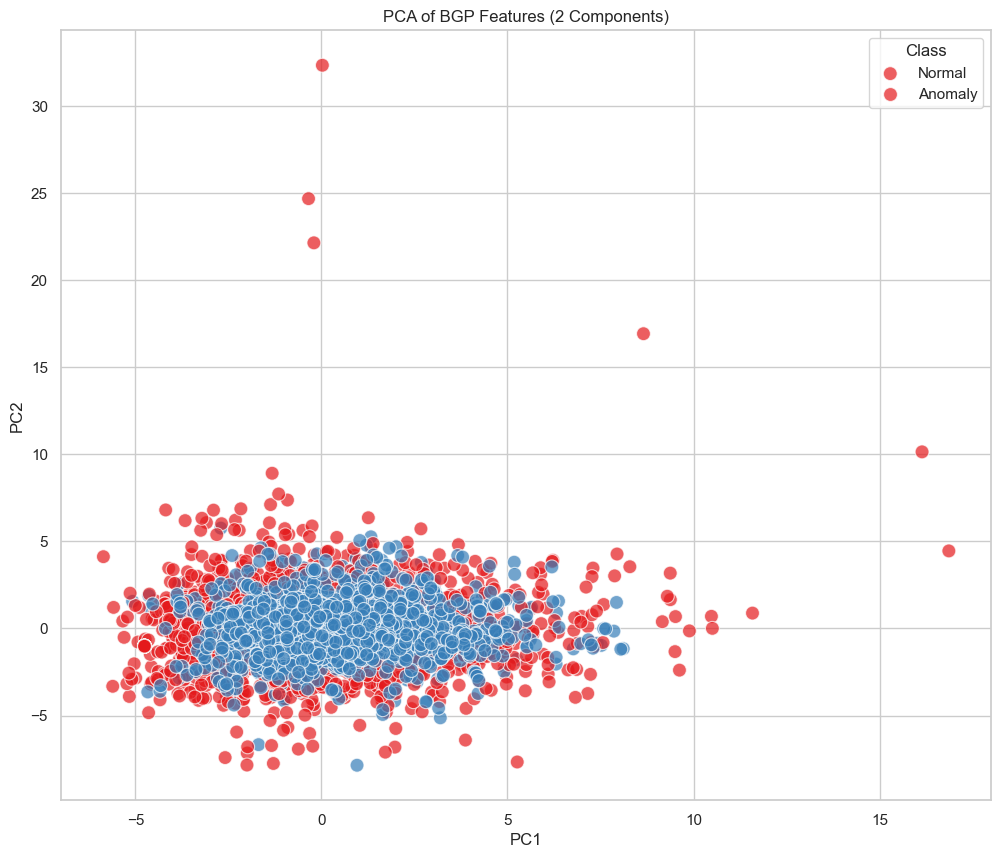

In [25]:
# Apply PCA to reduce to 2 dimensions for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_train.values

# Plot PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='class', data=pca_df, palette='Set1', s=100, alpha=0.7)
plt.title('PCA of BGP Features (2 Components)')
plt.legend(title='Class', labels=['Normal', 'Anomaly'])
plt.show()

<Figure size 1400x1200 with 0 Axes>

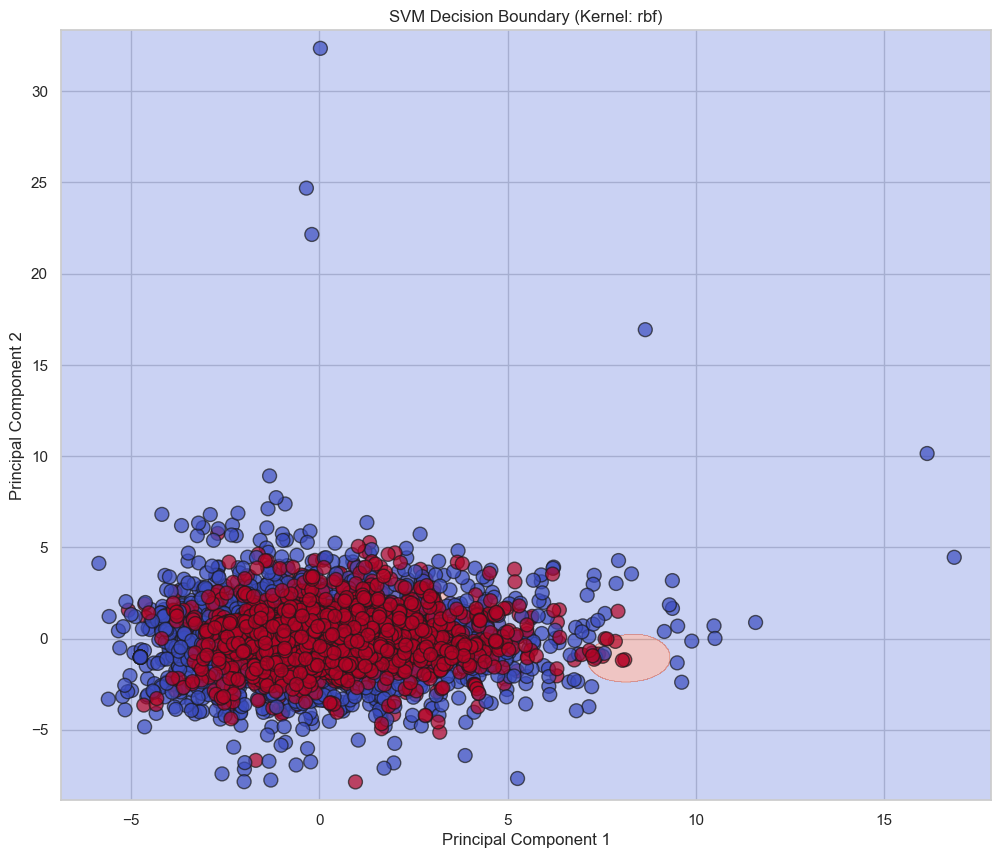

In [27]:
# Train an SVM on the PCA-transformed data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_scaled)

X_train_pca = X_pca
y_train_pca = y_train

y_test_pca = y_test

# Use best parameters from grid search but adapt to the 2D case
# best_params = grid_search.best_params_
svm_2d = SVC(
    C=best_params['svm__C'],
    gamma=best_params['svm__gamma'] if best_params['svm__gamma'] not in ['scale', 'auto'] else 'scale',
    kernel=best_params['svm__kernel'],
    probability=True
)
svm_2d.fit(X_train_pca, y_train_pca)

# Plot decision boundary
def plot_decision_boundary(X, y, model, ax=None):
    h = 0.02  # Step size in the mesh
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Get predictions for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    if ax is None:
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
    
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, alpha=0.7, edgecolors='k')
    return ax

plt.figure(figsize=(14, 12))
ax = plot_decision_boundary(X_pca, y_train.values, svm_2d)
plt.title(f'SVM Decision Boundary (Kernel: {best_params["svm__kernel"]})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

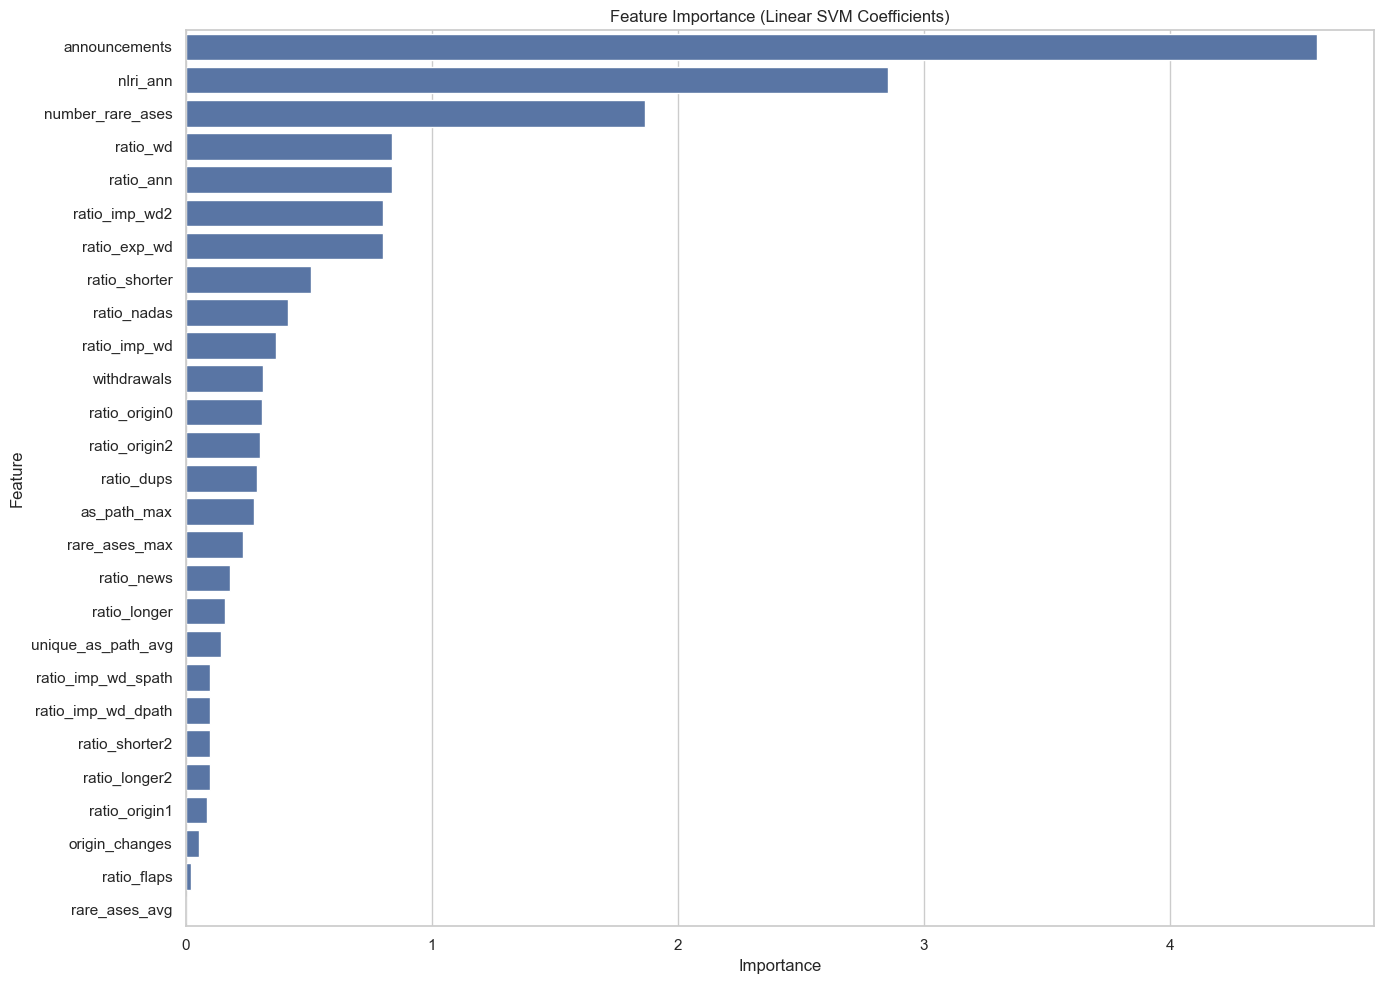

In [31]:
# Create and train a linear SVM for feature importance analysis
linear_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])
linear_svm.fit(X_train, y_train)

# Extract feature importance scores (coefficients)
importances = abs(linear_svm.named_steps['svm'].coef_[0])
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Linear SVM Coefficients)')
plt.tight_layout()
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

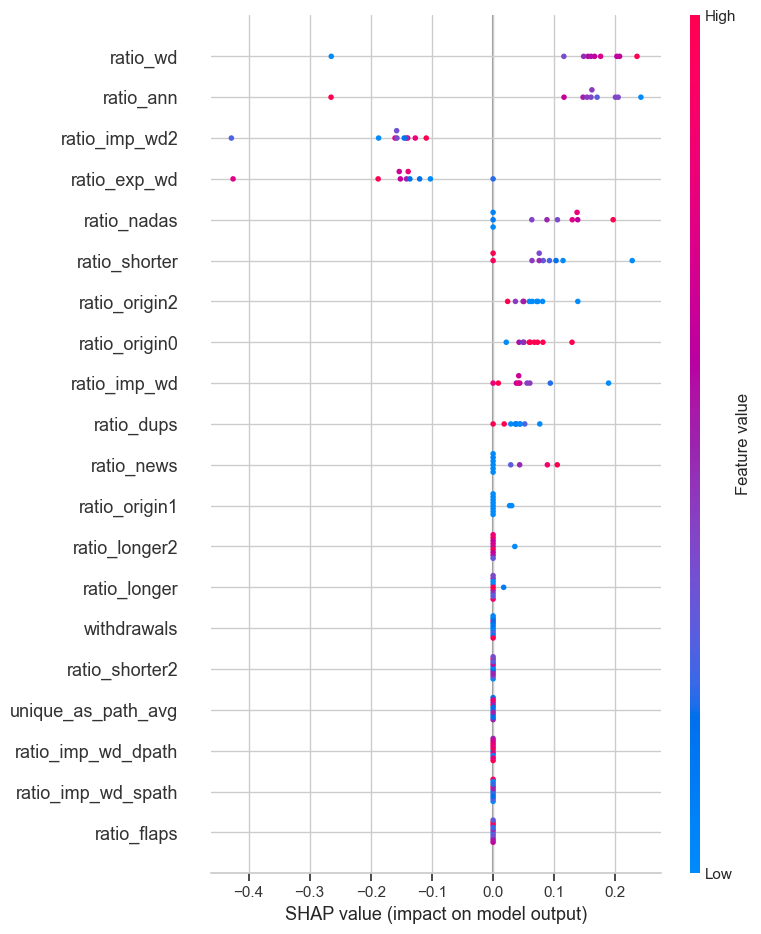

<Figure size 1200x800 with 0 Axes>

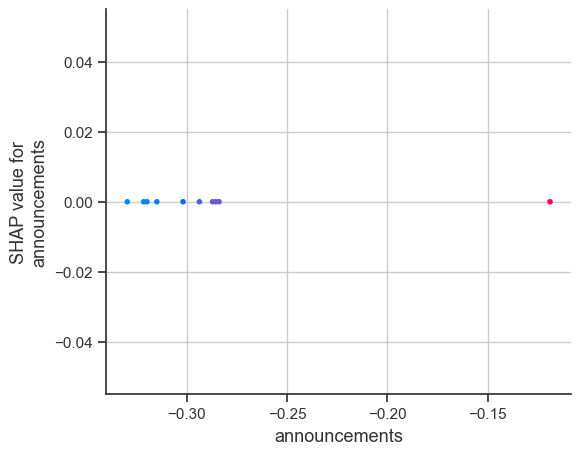

In [32]:
if EXPLAINABILITY_AVAILABLE:
    # Create a simpler model for SHAP analysis (to speed up computation)
    shap_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', probability=True))
    ])
    shap_model.fit(X_train, y_train)
    
    # Use a subset of training data as background for the explainer
    X_train_sample = X_train.sample(min(100, len(X_train)), random_state=42)
    X_train_transformed = shap_model.named_steps['scaler'].transform(X_train_sample)
    
    # Create a SHAP KernelExplainer
    def f(x):
        return shap_model.predict_proba(x)[:,1]
    
    explainer = shap.KernelExplainer(f, X_train_transformed)
    
    # Select a sample of test instances to explain
    X_test_sample = X_test.sample(min(10, len(X_test)), random_state=42)
    X_test_transformed = shap_model.named_steps['scaler'].transform(X_test_sample)
    
    # Compute SHAP values
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)
    
    # SHAP dependence plot for top feature
    top_feature_idx = np.argmax(np.abs(explainer.expected_value))
    top_feature = X_train.columns[top_feature_idx]
    
    plt.figure(figsize=(12, 8))
    shap.dependence_plot(top_feature_idx, shap_values, X_test_transformed, 
                         feature_names=X_train.columns)
else:
    print("SHAP analysis skipped because libraries are not installed.")

Intercept 0.2738554322009465
Prediction_local [-0.0345485]
Right: 0.07756743100677138


<Figure size 1200x600 with 0 Axes>

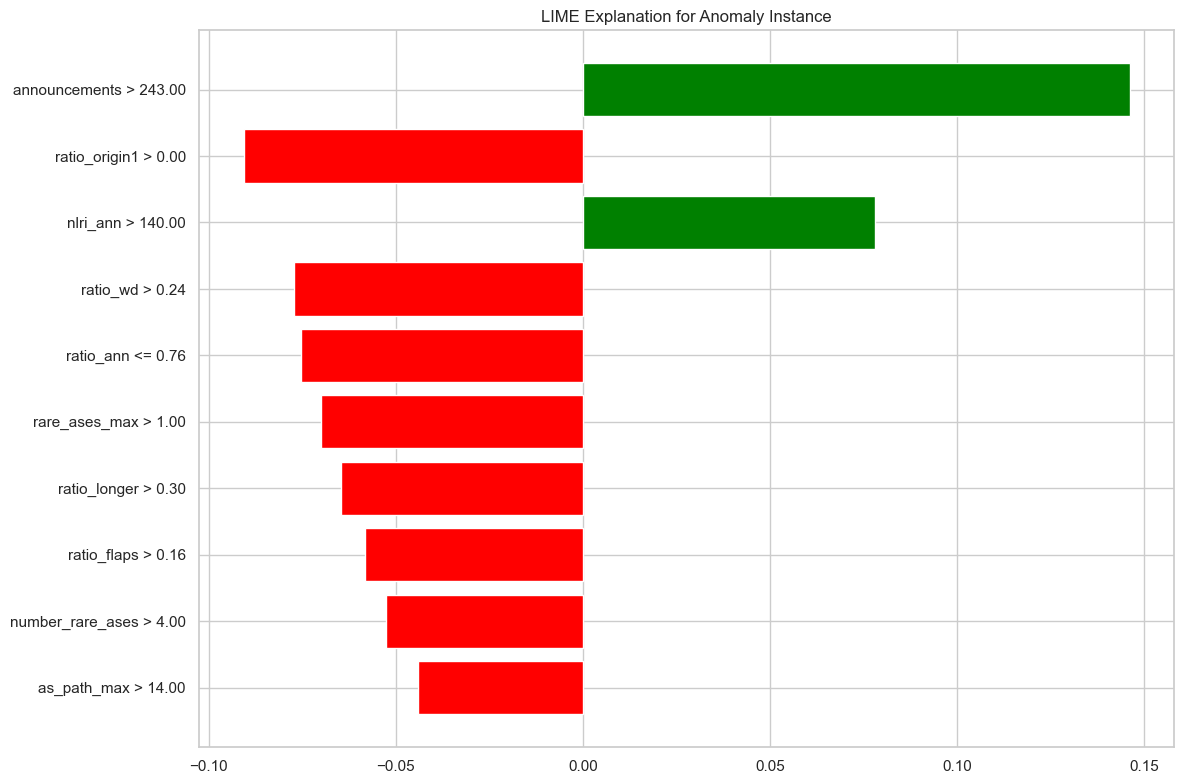

In [33]:
if EXPLAINABILITY_AVAILABLE:
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['Normal', 'Anomaly'],
        verbose=True,
        mode='classification'
    )
    
    # Find an anomaly instance to explain
    anomaly_indices = np.where(y_test == 1)[0]
    if len(anomaly_indices) > 0:
        # Pick an anomaly in the test set
        anomaly_idx = anomaly_indices[0]
        anomaly_instance = X_test.iloc[anomaly_idx].values
        
        # Generate LIME explanation
        lime_exp = lime_explainer.explain_instance(
            anomaly_instance, 
            best_model.predict_proba,
            num_features=10
        )
        
        # Plot the explanation
        plt.figure(figsize=(12, 6))
        lime_exp.as_pyplot_figure()
        plt.title("LIME Explanation for Anomaly Instance")
        plt.tight_layout()
        plt.show()
    else:
        print("No anomalies found in test set")
else:
    print("LIME analysis skipped because libraries are not installed.")